In [1]:
!curl -X GET "https://api.data.gov.in/resource/f4810b98-1adb-464b-830b-8f38f10288b4?api-key=579b464db66ec23bdd000001cdd3946e44ce4aad7209ff7b23ac571b&format=csv&offset=0&limit=10" -H  "accept: application/xml"

nationality,region,_2001,_2002,_2003,_2004,_2005,_2006,_2007,_2008,_2009,_2010
Canada,"NORTH AMERICA",88600,93598,107671,135884,157643,176567,208214,222364,224069,242372
U.S.A.,"NORTH AMERICA",329147,348182,410803,526120,611165,696739,799062,804933,827140,931292
Total,"NORTH AMERICA",417747,441780,518474,662004,768808,873306,1007276,1027297,1051209,1173664
Argentina,"CENTRAL AND SOUTH AMERICA",2906,1359,1805,2799,3313,4493,4992,5087,6011,7626
Brazil,"CENTRAL AND SOUTH AMERICA",3819,3622,4528,7397,7005,9148,10788,11530,13964,15219
Mexico,"CENTRAL AND SOUTH AMERICA",3473,3105,3563,4570,5398,6502,8299,9272,8185,10458
Others,"CENTRAL AND SOUTH AMERICA",11727,9586,11758,13399,19870,18602,18240,17616,18444,29425
Total,"CENTRAL AND SOUTH AMERICA",21925,17672,21654,28165,35586,38745,42319,43505,46604,62728
Austria,"WESTERN EUROPE",17787,13801,16903,21093,27187,28045,26692,25900,27930,32620
Belgium,"WESTERN EUROPE",18851,13945,17309,24007,25596,29156,34207,36277,34759,37709


In [36]:
#!/usr/bin/env python
import requests
import operator
import itertools
import numpy as np
import plotly.plotly as py
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# global variables

API_URI="https://api.data.gov.in/resource/f4810b98-1adb-464b-830b-8f38f10288b4"
API_KEY="579b464db66ec23bdd000001cdd3946e44ce4aad7209ff7b23ac571b"

In [4]:
def send_request(offset):
    response = requests.get(
                            API_URI, 
                            params={
                                    'format': 'json', 'offset': str(offset), 
                                    'limit': str(offset+10), 'api-key': API_KEY
                                   }, 
                            headers={'Accept': 'application/xml'}
                            )
    fields = response.json().get('fields')
    data = response.json().get('records')
    return fields, data

In [5]:
F, D = [], []
for offset in range(0, 200, 10):
    fields, data = send_request(offset)
    F.append(fields)
    D.append(data)

In [6]:
fields = [str(field) for field in F[0]]
fields

["{u'type': u'keyword', u'name': u'nationality'}",
 "{u'type': u'keyword', u'name': u'region'}",
 "{u'type': u'long', u'name': u'_2001'}",
 "{u'type': u'long', u'name': u'_2002'}",
 "{u'type': u'long', u'name': u'_2003'}",
 "{u'type': u'long', u'name': u'_2004'}",
 "{u'type': u'long', u'name': u'_2005'}",
 "{u'type': u'long', u'name': u'_2006'}",
 "{u'type': u'long', u'name': u'_2007'}",
 "{u'type': u'long', u'name': u'_2008'}",
 "{u'type': u'long', u'name': u'_2009'}",
 "{u'type': u'long', u'name': u'_2010'}"]

In [7]:
D = [item for sublist in D for item in sublist]
len(D)

88

In [8]:
def expand(d):
    if d == 'u.k.': d='united kingdom'
    elif d == 'u.a.e.': d='united arab emirates'
    elif d == 'u.s.a.': d='united states'
    return d
total_count = dict()
for _d in D:
    total = []
    nationality = _d.get('nationality')
    if nationality not in [None, 'Total', 'Others']:
        for year in _d.keys():
            if year not in ['nationality', 'region']:
                total.append(_d.get(year))
    
        total_count[expand(str(nationality).lower())] = sum(total)

In [9]:
total_count

{'afghanistan': 242186,
 'argentina': 40391,
 'australia': 1050752,
 'austria': 237958,
 'bahrein': 55576,
 'bangladesh': 4662993,
 'belgium': 271816,
 'bhutan': 73323,
 'brazil': 87020,
 'canada': 1656982,
 'china': 792881,
 'cis': 873471,
 'czechoslovakia': 58440,
 'denmark': 222653,
 'egypt': 47446,
 'ethiopia': 31409,
 'fiji': 20484,
 'finland': 188053,
 'france': 1572032,
 'germany': 1423375,
 'grand total': 40777832,
 'greece': 52297,
 'hong kong': 12244,
 'hungary': 38324,
 'indonesia': 150243,
 'iran': 271566,
 'ireland': 129848,
 'israel': 385428,
 'italy': 689855,
 'japan': 1121229,
 'jordan': 32180,
 'kenya': 199743,
 'korea': 604255,
 'kuwait': 35293,
 'malayasia': 1023274,
 'maldives': 361455,
 'mali': 4251,
 'mauritius': 188735,
 'maynnar': 76073,
 'mexico': 62825,
 'nepal': 701401,
 'netherland': 551549,
 'new zealand': 221171,
 'nigeria': 112396,
 'norway': 145757,
 'oman': 211259,
 'pakistan': 602211,
 'philippines': 139805,
 'poland': 138984,
 'portugal': 127054,
 'qa

In [10]:
from countrycode import countrycode

def get_code(country):
    return countrycode(codes=country, origin='country_name', target='iso3c')

codes = [(get_code(i), i) for i in total_count.keys() if len(get_code(i)) == 3 and get_code(i).isupper()]

In [11]:

data = [ dict(
        type = 'choropleth',
        locations = [i[0] for i in codes],
        z = [total_count.get(i[1]) for i in codes],
        text = [i[1] for i in codes],
        colorscale = 'Viridis',
        autocolorscale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Total Tourists<br>Raw Count'),
      ) ]

layout = dict(
    title = 'Tourists visiting India<br>(2001 - 2010)',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot(fig, validate=False, filename='d3-world-map' )


## Insight: 2
#### % of countries visiting India between 2001 to 2010

In [12]:
total_countries = 195.0  #source wikipedia
percent = len(total_count.keys())/total_countries
print '{} % of the total countries visited india from {} to {}'.format(percent, 2001, 2010)

0.353846153846 % of the total countries visited india from 2001 to 2010


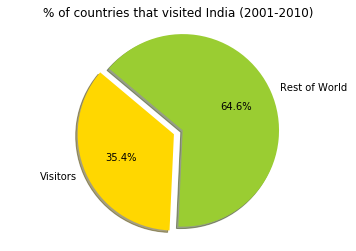

In [13]:
labels = 'Visitors', 'Rest of World'
sizes = [percent*100, 100-percent*100]
colors = ['gold', 'yellowgreen']
explode = (0.1, 0,)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('% of countries that visited India (2001-2010)')
plt.axis('equal')
plt.show()

## Insight: 3
#### Top/Bottom 5 countries that visited India between 2001 to 2010

In [14]:
sorted_x = sorted(total_count.items(), key=operator.itemgetter(1), reverse=True)
countries = [j for j in sorted_x if j[0] in [i[1] for i in codes]]
top_5 = countries[:5]
bottom_5 = countries[-5:]
print "{} are top 5 countries visiting India from {} to {}".format([i[0] for i in top_5], 2001, 2010)
print "{} are bottom 5 countries visiting India from {} to {}".format([i[0] for i in bottom_5], 2001, 2010)

['united states', 'united kingdom', 'bangladesh', 'sri lanka', 'canada'] are top 5 countries visiting India from 2001 to 2010
['qatar', 'fiji', 'zambia', 'hong kong', 'mali'] are bottom 5 countries visiting India from 2001 to 2010


In [15]:
print top_5

[('united states', 6284583), ('united kingdom', 6266931), ('bangladesh', 4662993), ('sri lanka', 1679242), ('canada', 1656982)]


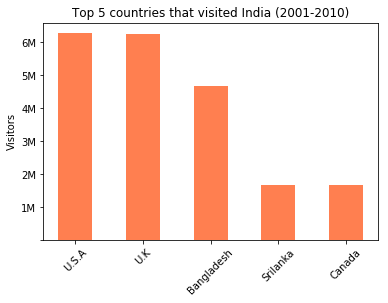

In [16]:
fig, ax = plt.subplots()
width = .50
ind = range(len(top_5))
plt.bar(ind, [i[1] for i in countries][:5], width=width, color="coral")
plt.title('Top 5 countries that visited India (2001-2010)')
plt.ylabel('Visitors') 
ax.set_yticklabels(['', '1M', '2M', '3M', '4M', '5M', '6M'], minor=False)
ax.set_xticklabels(['', 'U.S.A', 'U.K', 'Bangladesh', 'Srilanka', 'Canada'], rotation=45)
ax.set_alpha(0.8)
plt.show()

## Insight: 4
#### Region wise distribution showing country dominance for each

In [81]:
region_country_group = {}
for i in D:
    region = i.get('region')
    if region.strip().lower() in ['others','','stateless']:
        continue
    if region not in region_country_group:
        if i.get('nationality') != 'Total':
            region_country_group[i.get('region')] = [expand(str(i.get('nationality'))).lower()]
    else:
        if i.get('nationality') != 'Total':
            region_country_group[i.get('region')].append(expand(str(i.get('nationality')).lower()))
print region_country_group

{u'EAST ASIA': ['china', 'hong kong', 'japan', 'korea', 'others'], u' WEST ASIA': ['bahrein', 'israel', 'jordan', 'kuwait', 'oman', 'qatar', 'saudi arabia', 'syria', 'turkey', 'united arab emirates', 'yemen arab rep.', 'others'], u' EASTERN EUROPE': ['czechoslovakia', 'hungary', 'poland', 'cis', 'others'], u'AFRICA': ['egypt', 'ethiopia', 'kenya', 'mali', 'mauritius', 'nigeria', 'south africa', 'sudan', 'tanzania', 'zambia', 'others'], u'NORTH AMERICA': ['canada', 'united states'], u'AUSTRALASIA': ['australia', 'new zealand', 'fiji', 'others'], u'CENTRAL AND SOUTH AMERICA': ['argentina', 'brazil', 'mexico', 'others'], u'SOUTH EAST ASIA': ['indonesia', 'malayasia', 'maynnar', 'philippines', 'singapore', 'thailand', 'others'], u'SOUTH ASIA': ['afghanistan', 'iran', 'maldives', 'nepal', 'pakistan', 'bangladesh', 'sri lanka', 'bhutan'], u'WESTERN EUROPE': ['austria', 'belgium', 'denmark', 'finland', 'france', 'germany', 'greece', 'ireland', 'italy', 'netherland', 'norway', 'portugal', 'spa

75
75


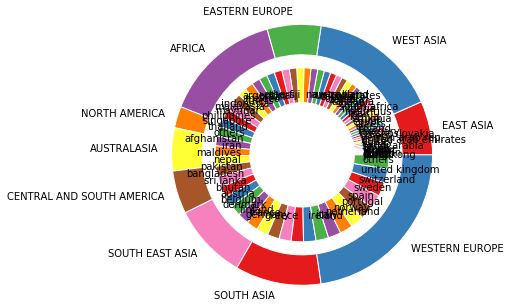

In [95]:
group_names = region_country_group.keys()
group_size = [len(v) for k, v in region_country_group.items()]
countries = reduce(operator.concat, region_country_group.values())
subgroup_names = countries
subgroup_size = range(1,76)
print len(countries)
print len(subgroup_size)
cs = plt.cm.Set1(np.arange(8))

fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.5, labels=group_names, colors=cs)
plt.setp( mypie, width=0.35, edgecolor='white')

mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=cs)
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

plt.show()